# Yelp Rating Prediction Dataset

Obtained from http://goo.gl/JyCnZq via [github](https://github.com/zhangxiangxiao/Crepe)
```
@misc{zhang2015characterlevel,
    title={Character-level Convolutional Networks for Text Classification},
    author={Xiang Zhang and Junbo Zhao and Yann LeCun},
    year={2015},
    eprint={1509.01626},
    archivePrefix={arXiv},
    primaryClass={cs.LG}
}
```

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import hashlib

TRAIN_DATASET_LOCATION = "../datasets/yelp/train.csv"
TEST_DATASET_LOCATION = "../datasets/yelp/test.csv"

### Validity check

In [2]:
VERIFY_CHECKSUM = True
CHECKSUM = '24bbad7486bc4922501457414e082686'

In [3]:
assert os.path.exists(TRAIN_DATASET_LOCATION)
assert os.path.exists(TEST_DATASET_LOCATION)

def verify_checksum(file, checksum):
    with open(file, "rb") as f:
        file_hash = hashlib.md5()
        while chunk := f.read(8192):
            file_hash.update(chunk)
    assert checksum == file_hash.hexdigest()
    print("Checksum matches")
    
if VERIFY_CHECKSUM:
    verify_checksum(TRAIN_DATASET_LOCATION, '1ab7961a45755fbcaf4af11b82ee43a0')
    verify_checksum(TEST_DATASET_LOCATION, '18e419b8b7e2d321d7811f7703569a89')

Checksum matches
Checksum matches


### Read data

##### For the analysis only `text` and `stars` will be used

In [4]:
pd.read_csv(TRAIN_DATASET_LOCATION, header=None, nrows=10)

,0,1
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...
5,5,Top notch doctor in a top notch practice. Can'...
6,5,Dr. Eric Goldberg is a fantastic doctor who ha...
7,1,I'm writing this review to give you a heads up...
8,2,Wing sauce is like water. Pretty much a lot of...
9,3,Decent range somewhat close to the city. The ...


In [5]:
df_yelp_train = pd.read_csv(TRAIN_DATASET_LOCATION, header=None)
df_yelp_train.columns = ['target', 'text']
df_yelp_train.shape

(650000, 2)

In [6]:
df_yelp_train.head()

,target,text
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


Text(0.5, 0, 'Count')

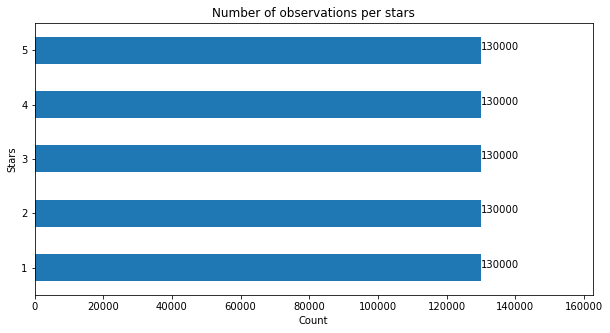

In [7]:
vc = df_yelp_train.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per stars', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Stars')
ax.set_xlabel('Count')

### Export File

In [8]:
PREPROCESSED_FILE = '../datasets/preprocessed/yelp_train.csv'
df_yelp_train.to_csv(PREPROCESSED_FILE, index=False)

### Detect Non-English texts

In [9]:
import fasttext
import numpy as np
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()

LANGUAGE_DETECTION_MODEL = "../fasttext/language_identification/lid.176.bin" #https://fasttext.cc/docs/en/language-identification.html
model = fasttext.load_model(LANGUAGE_DETECTION_MODEL)

In [10]:
def get_language(paragraph, k=None, return_all=False, min_certainty=0.25):
    if pd.isna(paragraph):
        return np.nan
    sentences = [line for line in paragraph.split("\n") if line != '']
    if len(sentences) < 1:
        return np.nan
    class_labels, certainties = model.predict(sentences, k)
    # sum certainties per class label and then divide by length -> avg certainty
    class_lookup, indexed_lang = np.unique(np.hstack(class_labels), return_inverse=True)
    summed_certainties = np.bincount(indexed_lang, weights=np.hstack(certainties))/len(sentences)
    if return_all:
        return dict(zip(class_lookup, summed_certainties))
    
    # get most likely lang
    lang_id = np.argmax(summed_certainties)
    if summed_certainties[lang_id] < min_certainty:
        return np.nan
    return class_lookup[lang_id]        

In [11]:
df_yelp_train['lang'] = df_yelp_train.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/650000 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

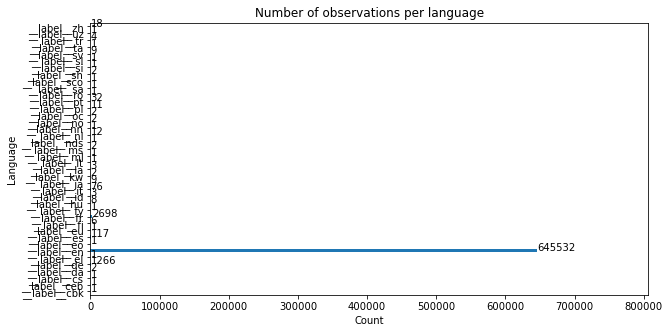

In [12]:
vc = df_yelp_train.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [13]:
vc.nlargest(5)

__label__en    645532
__label__fr      2698
__label__de      1266
__label__es       117
__label__it        76
Name: lang, dtype: int64

In [14]:
f"{vc['__label__en']/df_yelp_train.shape[0]*100:.4f}% of samples are english" 

'99.3126% of samples are english'

### Test Set analysis

In [15]:
df_yelp_test = pd.read_csv(TEST_DATASET_LOCATION, header=None)
df_yelp_test.columns = ['target', 'text']
df_yelp_test.shape

(50000, 2)

In [16]:
df_yelp_test.head()

,target,text
0,1,I got 'new' tires from them and within two wee...
1,1,Don't waste your time. We had two different p...
2,1,All I can say is the worst! We were the only 2...
3,1,I have been to this restaurant twice and was d...
4,1,Food was NOT GOOD at all! My husband & I ate h...


Text(0.5, 0, 'Count')

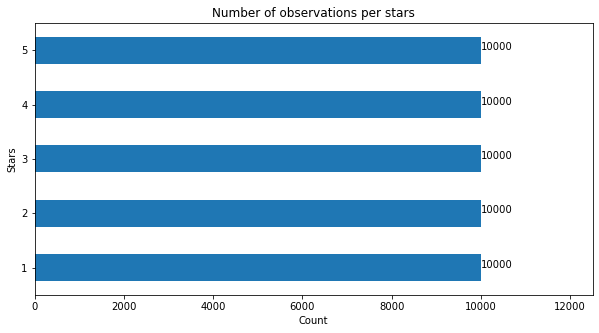

In [17]:
vc = df_yelp_test.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per stars', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Stars')
ax.set_xlabel('Count')

### Export File

In [18]:
PREPROCESSED_FILE = '../datasets/preprocessed/yelp_test.csv'
df_yelp_test.to_csv(PREPROCESSED_FILE, index=False)

In [19]:
df_yelp_test['lang'] = df_yelp_test.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/50000 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

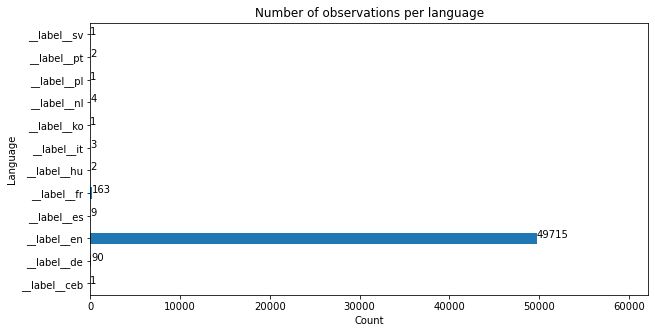

In [20]:
vc = df_yelp_test.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [21]:
vc.nlargest(5)

__label__en    49715
__label__fr      163
__label__de       90
__label__es        9
__label__nl        4
Name: lang, dtype: int64

In [22]:
f"{vc['__label__en']/df_yelp_test.shape[0]*100:.4f}% of samples are english" 

'99.4300% of samples are english'